In [1]:
import numpy as np
from os.path import dirname, abspath, join as pjoin
from Corrfunc.theory.DD import DD
from Corrfunc.io import read_catalog
from Corrfunc.utils import convert_3d_counts_to_cf
from Corrfunc.mocks import *
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import glob, time 

from astropy.io import fits as fits
from astropy.table import Table, vstack
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable

import healpy as hp
import math

import sys
sys.path.append('/global/homes/l/lbigwood/LSS/py')
import LSS
import LSS.SV3
import LSS.SV3.cattools as cattools

from desitarget.targets import desi_mask, bgs_mask, mws_mask 
from desitarget.geomask import get_imaging_maskbits 

In [2]:
#https://arxiv.org/pdf/2106.13120.pdf

to_grab=glob.glob('/global/cfs/cdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/bright/targets-bright-hp-*.fits') 

# very good practice to apply sorted, otherwise the file ordering will be random 	and non-repeatable.  
to_grab = sorted(to_grab) 

hp_stack = []

#do timer as takes a while
start = time.time() 

#total number of pixels, not quite sure where this has come from as npix is less than this above 


mmask = 'BGS_TARGET'
ttype = 'BGS_BRIGHT'

#loop through pixels
for i, x in enumerate(to_grab):
    x = fits.open(x)
    f = np.array(x[1].data)[['RA','DEC','TARGETID', 'BGS_TARGET', 'MWS_TARGET','PHOTSYS']]
    #mask for bgs objects
    
    is_bgs = (f[mmask] & bgs_mask[ttype]) != 0
    #idx = np.arange(len(x))[is_bgs]
    #x = x.iloc[idx] 
    hp_stack.append(f[is_bgs])

    #more timing stuff
    if (i % 20) == 0:
        runtime = (time.time() - start)

        print('Runtime of {:.6f} seconds after {:d} pixels'.format(runtime, i))

    

data_stack = np.concatenate(hp_stack)      
        

data_stack = Table(data_stack)
mask,idx = np.unique(data_stack['TARGETID'],return_index=True)
data_stack = data_stack[idx]





data_stack

Runtime of 0.306429 seconds after 0 pixels
Runtime of 14.456791 seconds after 20 pixels
Runtime of 23.959308 seconds after 40 pixels
Runtime of 33.413412 seconds after 60 pixels
Runtime of 41.463672 seconds after 80 pixels
Runtime of 50.475663 seconds after 100 pixels
Runtime of 61.290347 seconds after 120 pixels
Runtime of 67.998618 seconds after 140 pixels
Runtime of 75.542424 seconds after 160 pixels
Runtime of 84.159753 seconds after 180 pixels
Runtime of 92.216583 seconds after 200 pixels
Runtime of 99.204210 seconds after 220 pixels
Runtime of 105.108782 seconds after 240 pixels
Runtime of 116.328243 seconds after 260 pixels
Runtime of 127.240743 seconds after 280 pixels
Runtime of 145.424101 seconds after 300 pixels
Runtime of 159.516423 seconds after 320 pixels
Runtime of 172.382427 seconds after 340 pixels
Runtime of 183.033160 seconds after 360 pixels
Runtime of 191.021276 seconds after 380 pixels
Runtime of 199.881204 seconds after 400 pixels
Runtime of 212.827866 seconds af

RA,DEC,TARGETID,BGS_TARGET,MWS_TARGET,PHOTSYS
float64,float64,int64,int64,int64,bytes1
59.60086559409994,-68.12683131313393,39626498281308189,131074,0,S
60.00983139575825,-68.16966639837612,39626498281308607,131074,0,S
60.01124019929327,-68.16379040745758,39626498281308610,131074,0,S
60.06731663474673,-68.1403940503445,39626498281308675,131074,0,S
60.27687723658043,-68.1477166136955,39626498285502547,131074,0,S
60.35173082770005,-68.1384524183673,39626498285502613,131074,0,S
60.354809035658526,-68.15736062454609,39626498285502619,131074,0,S
60.41502834204189,-68.14758441322456,39626498285502711,131074,0,S
60.57191230896668,-68.15293728255374,39626498285502939,131074,0,S


In [7]:
#select DECALS
data_stack = data_stack[(data_stack['PHOTSYS']=='S')]

In [2]:
"""

#have to use ledger instead

#working with main survey randoms here i.e not sv3
to_grab=glob.glob('/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/main/bright/mtl-bright-hp-*.ecsv') 

# very good practice to apply sorted, otherwise the file ordering will be random 	and non-repeatable.  
to_grab = sorted(to_grab) 

hp_stack = []

#do timer as takes a while
start = time.time() 

#total number of pixels, not quite sure where this has come from as npix is less than this above 
npix_todo = 200000

mmask = 'BGS_TARGET'
ttype = 'BGS_BRIGHT'

#loop through pixels
for i, x in enumerate(to_grab):
    x = pd.read_csv(x, comment='#', delimiter='\s+')# usecols=['RA', 'DEC', 'TARGETID', 'BGS_TARGET', 'MWS_TARGET'])

    #mask for bgs objects
    is_bgs = (x[mmask] & bgs_mask[ttype]) != 0
    idx = np.arange(len(x))[is_bgs]
    x = x.iloc[idx] 
    hp_stack.append(x)

    #more timing stuff
    if (i % 100) == 0:
        runtime = (time.time() - start)

        print('Runtime of {:.6f} seconds after {:d} pixels'.format(runtime, i))

    if i > npix_todo:
        break
        
# Create a big table from the list of tables.  
data_stack = pd.concat(hp_stack, ignore_index=True)

#unique targets only and put it in right table format
mask,idx = np.unique(data_stack['TARGETID'],return_index=True)
data_stack = data_stack.iloc[idx]
data_stack = Table.from_pandas(data_stack)

#more timing stuff
runtime = (time.time() - start)
print('\n\nTotal runtime of {:.6f} seconds after {:d} pixels'.format(runtime, npix_todo))

data_stack
"""

Runtime of 0.079026 seconds after 0 pixels
Runtime of 5.092527 seconds after 100 pixels
Runtime of 13.394444 seconds after 200 pixels
Runtime of 20.111911 seconds after 300 pixels
Runtime of 29.222286 seconds after 400 pixels
Runtime of 37.222293 seconds after 500 pixels
Runtime of 44.763980 seconds after 600 pixels
Runtime of 53.214504 seconds after 700 pixels
Runtime of 62.521253 seconds after 800 pixels
Runtime of 68.897875 seconds after 900 pixels
Runtime of 75.234223 seconds after 1000 pixels
Runtime of 81.831342 seconds after 1100 pixels
Runtime of 91.303452 seconds after 1200 pixels
Runtime of 100.772280 seconds after 1300 pixels
Runtime of 111.151940 seconds after 1400 pixels
Runtime of 118.917232 seconds after 1500 pixels
Runtime of 127.665787 seconds after 1600 pixels
Runtime of 136.198352 seconds after 1700 pixels
Runtime of 144.005388 seconds after 1800 pixels
Runtime of 150.913178 seconds after 1900 pixels
Runtime of 161.082563 seconds after 2000 pixels
Runtime of 170.7749

RA,DEC,REF_EPOCH,PARALLAX,PMRA,PMDEC,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,SCND_TARGET,NUMOBS_MORE,NUMOBS,Z,ZWARN,ZTILEID,Z_QN,IS_QSO_QN,DELTACHI2,TARGET_STATE,TIMESTAMP,VERSION,PRIORITY
float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,float64,int64,float64,str16,str25,str5,int64
59.60086559409994,-68.12683131313392,0.0,0.0,0.0,0.0,39626498281308189,1152921504606846976,131074,0,0.2085393333137383,516,2100,2,0,2,0,-1.0,-1,-1,-1.0,-1,-1.0,BGS_BRIGHT|UNOBS,2021-05-13T08:15:37+00:00,1.1.1,2100
60.00983139575825,-68.16966639837612,0.0,0.0,0.0,0.0,39626498281308607,1152921504606846976,131074,0,0.024925504385559738,516,2100,2,0,2,0,-1.0,-1,-1,-1.0,-1,-1.0,BGS_BRIGHT|UNOBS,2021-05-13T08:15:37+00:00,1.1.1,2100
60.01124019929327,-68.16379040745758,0.0,0.0,0.0,0.0,39626498281308610,5764607523034234880,131074,0,0.5879754509121197,575,2100,2,131072,2,0,-1.0,-1,-1,-1.0,-1,-1.0,BGS_BRIGHT|UNOBS,2021-05-13T08:15:37+00:00,1.1.1,2100
60.067316634746724,-68.1403940503445,0.0,0.0,0.0,0.0,39626498281308675,1152921504606846976,131074,0,0.14655963849075593,516,2100,2,0,2,0,-1.0,-1,-1,-1.0,-1,-1.0,BGS_BRIGHT|UNOBS,2021-05-13T08:15:37+00:00,1.1.1,2100
60.27687723658043,-68.1477166136955,0.0,0.0,0.0,0.0,39626498285502547,1152921504606846976,131074,0,0.5968644826507952,516,2100,2,0,2,0,-1.0,-1,-1,-1.0,-1,-1.0,BGS_BRIGHT|UNOBS,2021-05-13T08:15:37+00:00,1.1.1,2100
60.351730827700045,-68.1384524183673,0.0,0.0,0.0,0.0,39626498285502613,1152921504606846976,131074,0,0.3251615652075673,516,2100,2,0,2,0,-1.0,-1,-1,-1.0,-1,-1.0,BGS_BRIGHT|UNOBS,2021-05-13T08:15:37+00:00,1.1.1,2100
60.35480903565853,-68.15736062454609,0.0,0.0,0.0,0.0,39626498285502619,1152921504606846976,131074,0,0.9714658296060088,516,2100,2,0,2,0,-1.0,-1,-1,-1.0,-1,-1.0,BGS_BRIGHT|UNOBS,2021-05-13T08:15:37+00:00,1.1.1,2100
60.41502834204189,-68.14758441322456,0.0,0.0,0.0,0.0,39626498285502711,1152921504606912513,131074,0,0.98602725407379,517,2100,2,0,2,0,-1.0,-1,-1,-1.0,-1,-1.0,BGS_BRIGHT|UNOBS,2021-05-13T08:15:37+00:00,1.1.1,2100
60.57191230896668,-68.15293728255374,0.0,0.0,0.0,0.0,39626498285502939,1152921504606846976,131074,0,0.2485029442343407,516,2100,2,0,2,0,-1.0,-1,-1,-1.0,-1,-1.0,BGS_BRIGHT|UNOBS,2021-05-13T08:15:37+00:00,1.1.1,2100


In [ ]:
#angular correlation function for mock data.  
#https://corrfunc.readthedocs.io/en/master/modules/converting_ddtheta_mocks.html?highlight=wtheta


import numpy as np
import Corrfunc
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf


# Read the supplied galaxies on a periodic box
#f = fits.open('/global/cscratch1/sd/mjwilson/desi/BGS/lumfn/MXXL/bright_v0.9.fits')
#mxxl=f[1].data

data_stack_small = data_stack[((data_stack['RA']>180) & (data_stack['RA']<210) & (data_stack['DEC']>0) & (data_stack['DEC']<30))]

RA = data_stack_small['RA']
DEC = data_stack_small['DEC']
N = len(RA)

# Read the supplied randoms catalog
f = fits.open('/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/randoms/resolve/randoms-1-0.fits')
random1=f[1].data

random1_small = random1[((random1['RA']>180) & (random1['RA']<210) & (random1['DEC']>0) & (random1['DEC']<30))]

rand_RA = random1_small['RA']
rand_DEC = random1_small['DEC']
rand_N = len(rand_RA)

# Setup the bins
nbins = 30
bins = np.logspace(-3, 1, nbins + 1, base=10)
#bins = np.linspace(0.001, 10.0, nbins + 1)

# Number of threads to use
nthreads = 2

# Auto pair counts in DD
autocorr=1
DD_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC)

# Cross pair counts in DR
autocorr=0
DR_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC,RA2=rand_RA, DEC2=rand_DEC)

# Auto pairs counts in RR
autocorr=1
RR_counts = DDtheta_mocks(autocorr, nthreads, bins, rand_RA, rand_DEC)

# All the pair counts are done, get the angular correlation function
wtheta = convert_3d_counts_to_cf(N, N, rand_N, rand_N, DD_counts, DR_counts,DR_counts, RR_counts)

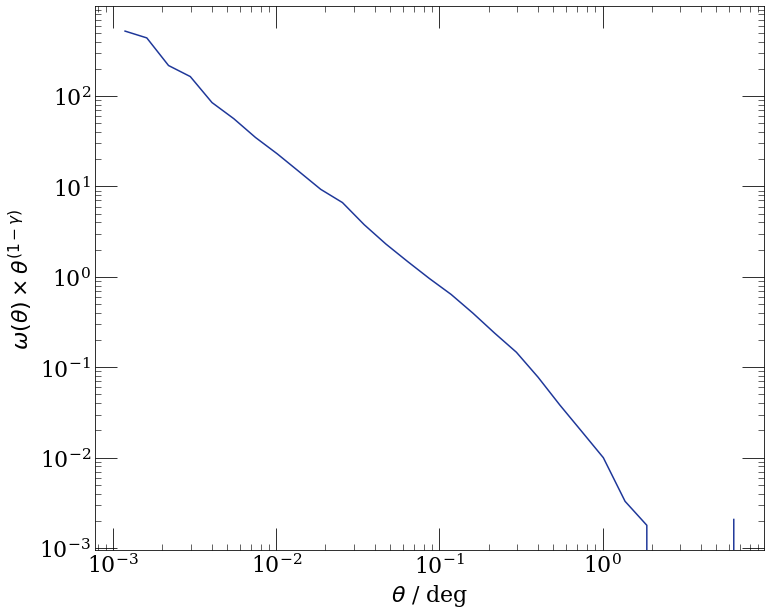

In [12]:
plt.rc('xtick',direction='in',labelsize=22,top=True)
plt.rc('ytick',direction='in',labelsize=22, right = True)
plt.rc('xtick.major',size = 22)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 22)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 22)
plt.rc('legend',fontsize=22)
plt.rc('font', family='serif',size=20)


bins = np.logspace(-3, 1, nbins + 1, base=10)
x_axis = []
for i in range(len(bins)-1):
    x_axis.append((bins[i]+bins[i+1])/2)

y_axis = []
for i in range(len(x_axis)):
    y_axis.append(wtheta[i]*x_axis[i]**(1-1.8))
    
plt.figure(figsize=(12,10))
plt.plot(x_axis, y_axis,color='#1e3799')
plt.xlabel(r'$\theta$ / deg')
plt.ylabel(r'$\omega (\theta)\times \theta^{(1-\gamma)}$')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('corrfunc.png',bbox_inches='tight')